In [16]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json


file_dir = "/data03/sunyi/time_constrained_cot/outputs/1_10"
model_list = [
    "Qwen/QwQ-32B-Preview",
    "Qwen/Qwen2.5-32B-Instruct", 
    "Qwen/Qwen2.5-14B-Instruct", 
    "Qwen/Qwen2.5-7B-Instruct", 
    "Qwen/Qwen2.5-3B-Instruct", 
    "Qwen/Qwen2.5-1.5B-Instruct",
    "mistralai/Mistral-Small-Instruct-2409",
    "mistralai/Mistral-Nemo-Instruct-2407",
    "mistralai/Ministral-8B-Instruct-2410",
    "mistralai/Mathstral-7B-v0.1",
    "google/gemma-2-27b-it",
    "google/gemma-2-9b-it",
    "google/gemma-2-2b-it",
    "microsoft/phi-4",
    "microsoft/Phi-3-medium-128k-instruct",
    "microsoft/Phi-3-small-128k-instruct",
    "microsoft/Phi-3-mini-128k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
]

In [17]:
PROMP_LIST = [ "-aav", "-c2f", "-direct", "-sbs", "-quick", "-aav-hard", "-c2f-hard", "-direct-hard", "-sbs-hard", "-quick-hard"]
# PROMP_LIST = ["-sbs-hard", "-sbs", "-c2f", "-kf", "-aav"]


MODEL_SERIES_MAP = {
    "Qwen/QwQ-32B-Preview": "qwen",
    "Qwen/Qwen2.5-32B-Instruct": "qwen",
    "Qwen/Qwen2.5-14B-Instruct": "qwen",
    "Qwen/Qwen2.5-7B-Instruct": "qwen",
    "Qwen/Qwen2.5-3B-Instruct": "qwen",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen",
    "google/gemma-2-2b-it": "gemma",
    "google/gemma-2-9b-it": "gemma",
    "google/gemma-2-27b-it": "gemma",
    "mistralai/Mathstral-7B-v0.1": "mistral",
    "mistralai/Ministral-8B-Instruct-2410": "mistral",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral",
    "mistralai/Mistral-Small-Instruct-2409": "mistral",
    "microsoft/phi-4": "phi4",
    "microsoft/Phi-3-medium-128k-instruct": "phi3medium",
    "microsoft/Phi-3-small-128k-instruct": "phi3small",
    "microsoft/Phi-3.5-mini-instruct": "phi3mini",
    "microsoft/Phi-3-mini-128k-instruct": "phi3mini",
}


MODEL_SERIES_PROMPT_TYPE_MAP = {
    "qwen": ["qwen" + prompt for prompt in PROMP_LIST],
    "mistral": ["mistral"+prompt for prompt in PROMP_LIST],
    "gemma": ["gemma"+prompt for prompt in PROMP_LIST],
    "phi3mini": ["phi3mini"+prompt for prompt in PROMP_LIST],
    "phi3small": ["phi3small"+prompt for prompt in PROMP_LIST],
    "phi3medium": ["phi3medium"+prompt for prompt in PROMP_LIST],
    "phi4": ["phi4"+prompt for prompt in PROMP_LIST],
}

In [18]:
def gen_budget_list(budget, data_name, model):
    if budget < 0:
        return [-1]
    elif budget == 0:
        return [25]
    else:
        if model in ["Qwen/QwQ-32B-Preview", "Skywork/Skywork-o1-Open-Llama-3.1-8B", "PowerInfer/SmallThinker-3B-Preview"]:
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 1201, 50):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 2401, 50):
                    budget_list.append(i)
        else:    
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 601, 25):
                    budget_list.append(i)
                # for i in range(600, 1001, 50):
                #     budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 1201, 50):
                    budget_list.append(i)
        return budget_list

In [19]:
dataset = "math500"
something = "_-1_seed0_t0.0_s0_e-1"

In [20]:
from typing import Union, Any, Iterable
from pathlib import Path

def load_jsonl(file: Union[str, Path]) -> Iterable[Any]:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                yield json.loads(line)
            except:
                print("Error in loading:", line)
                exit()

def get_accs(metric_path):
    with open(metric_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    acc = data["acc"]
    level_acc = data["level_acc"]
    subject_acc = data["subject_acc"]
    
    return acc, level_acc, subject_acc

In [21]:
model_acc_dicts = {}
model_level_acc_dicts = {}
model_subject_acc_dicts = {}

for model in model_list:
    model_acc_dict = {}
    model_level_acc_dict = {}
    model_subject_acc_dict = {}
    budget_list = gen_budget_list(1, dataset, model)
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        acc_list = []
        level_acc_list = []
        subject_acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            acc, level_acc, subject_acc = get_accs(file_path)
            acc_list.append(acc)
            level_acc_list.append(level_acc)
            subject_acc_list.append(subject_acc)
        model_acc_dict[prompt_type] = acc_list
        model_level_acc_dict[prompt_type] = level_acc_list
        model_subject_acc_dict[prompt_type] = subject_acc_list
    model_acc_dicts[model] = model_acc_dict
    model_level_acc_dicts[model] = model_level_acc_dict
    model_subject_acc_dicts[model] = model_subject_acc_dict

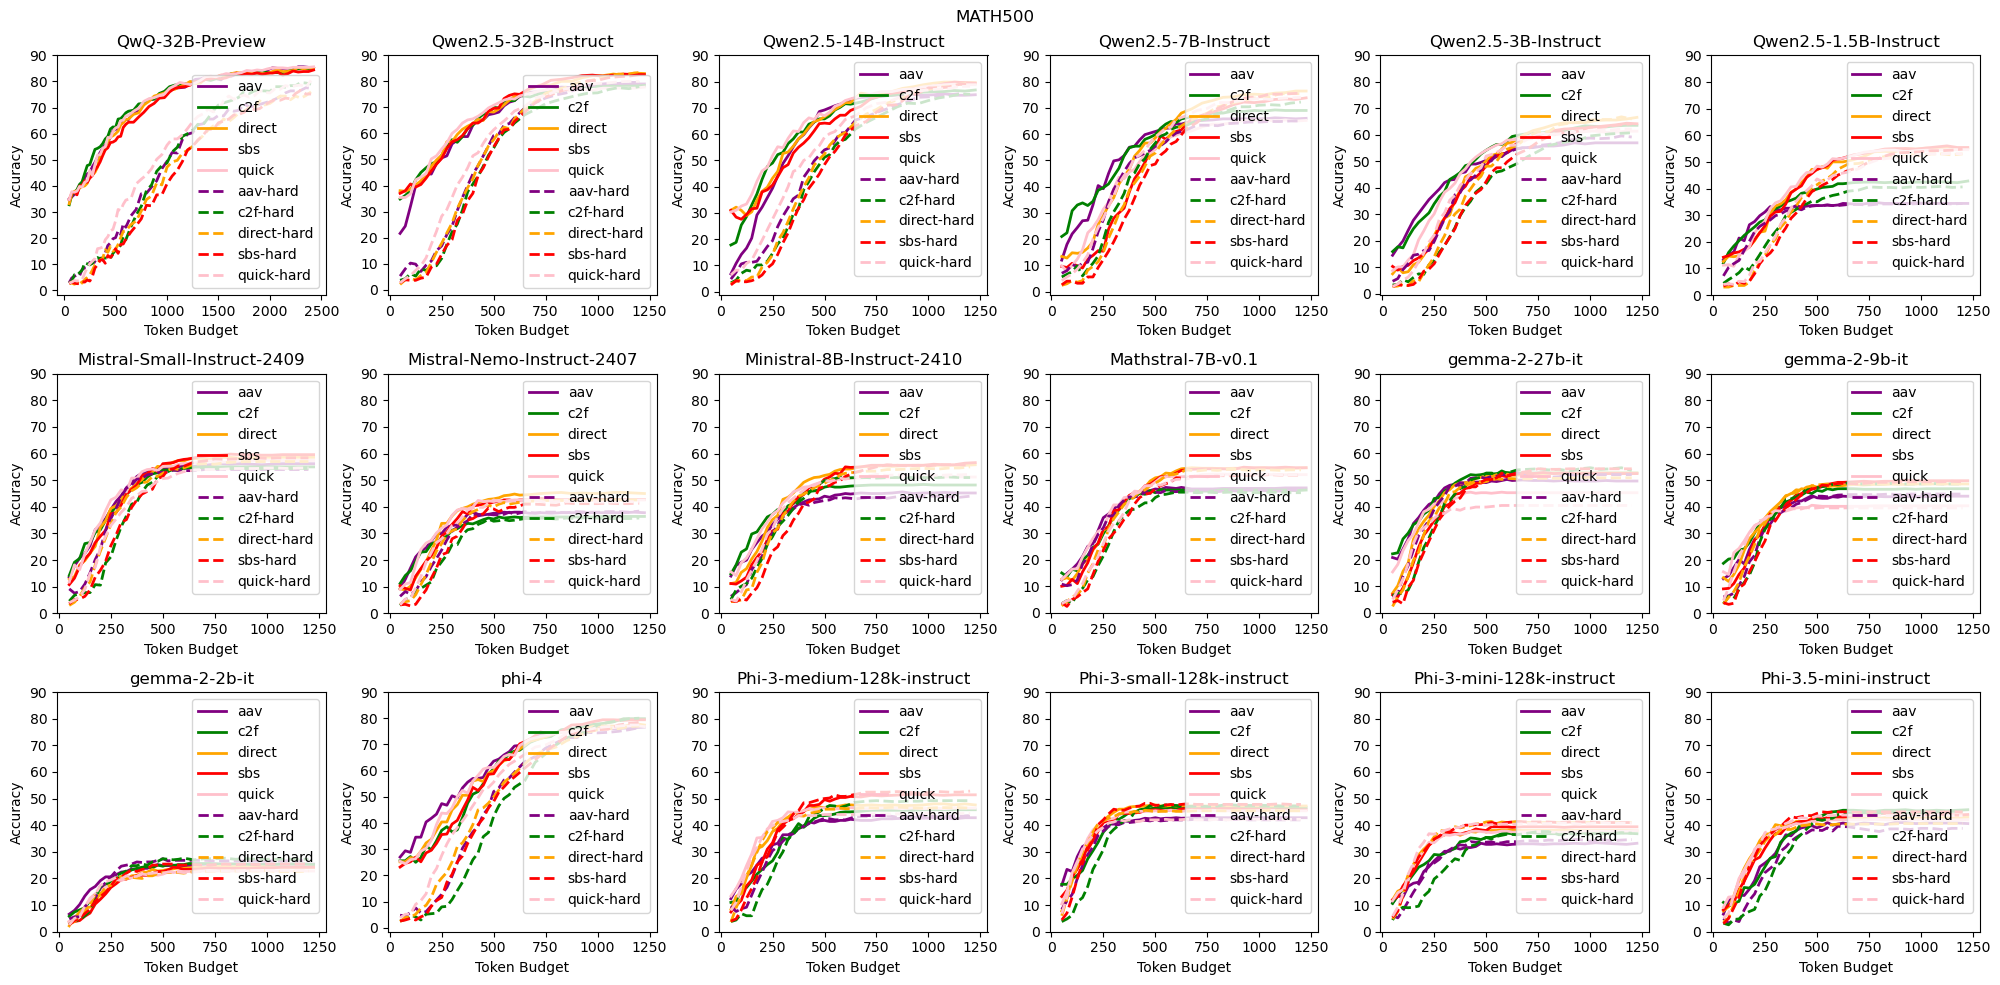

In [22]:
# Create a 2x3 subplot
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
marker_size = 5  # Set the desired marker size
line_width = 2   # Set the desired line width

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot all lines first without labels
for index, model in enumerate(model_list):
    budget_list = gen_budget_list(1, dataset, model)
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        if "sbs-hard" in prompt_type:
            axs[index].plot(budget_list[1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
        elif "direct-hard" in prompt_type:
            axs[index].plot(budget_list[1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
        elif "quick-hard" in prompt_type:
            axs[index].plot(budget_list[1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
        elif "c2f-hard" in prompt_type:
            axs[index].plot(budget_list[1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="green", label="c2f-hard", linewidth=line_width)
        elif "aav-hard" in prompt_type:
            axs[index].plot(budget_list[1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="purple", label="aav-hard", linewidth=line_width)
        elif "sbs" in prompt_type:
            axs[index].plot([budget + 25 for budget in budget_list], model_acc_dicts[model][prompt_type], linestyle='-', color="red", label="sbs", linewidth=line_width)
        elif "direct" in prompt_type:
            axs[index].plot([budget + 25 for budget in budget_list], model_acc_dicts[model][prompt_type], linestyle='-', color="orange", label="direct", linewidth=line_width)
        elif "quick" in prompt_type:
            axs[index].plot([budget + 25 for budget in budget_list], model_acc_dicts[model][prompt_type], linestyle='-', color="pink", label="quick", linewidth=line_width)
        elif "c2f" in prompt_type:
            axs[index].plot([budget + 25 for budget in budget_list], model_acc_dicts[model][prompt_type], linestyle='-', color="green", label="c2f", linewidth=line_width)
        # elif "kf" in prompt_type:
        #     axs[index].plot([budget + 25 for budget in budget_list], model_acc_dicts[model][prompt_type], linestyle='-', color="blue", label="kf", linewidth=line_width)
        elif "aav" in prompt_type:
            axs[index].plot([budget + 25 for budget in budget_list], model_acc_dicts[model][prompt_type], linestyle='-', color="purple", label="aav", linewidth=line_width)
        
        axs[index].set_xlabel("Token Budget")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()
        
        # Set y-axis and x-axis ticks
        axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
        # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

# set the title
plt.suptitle(f"{dataset}".upper())
# Adjust layout
plt.tight_layout()

KeyError: 'Level 1'

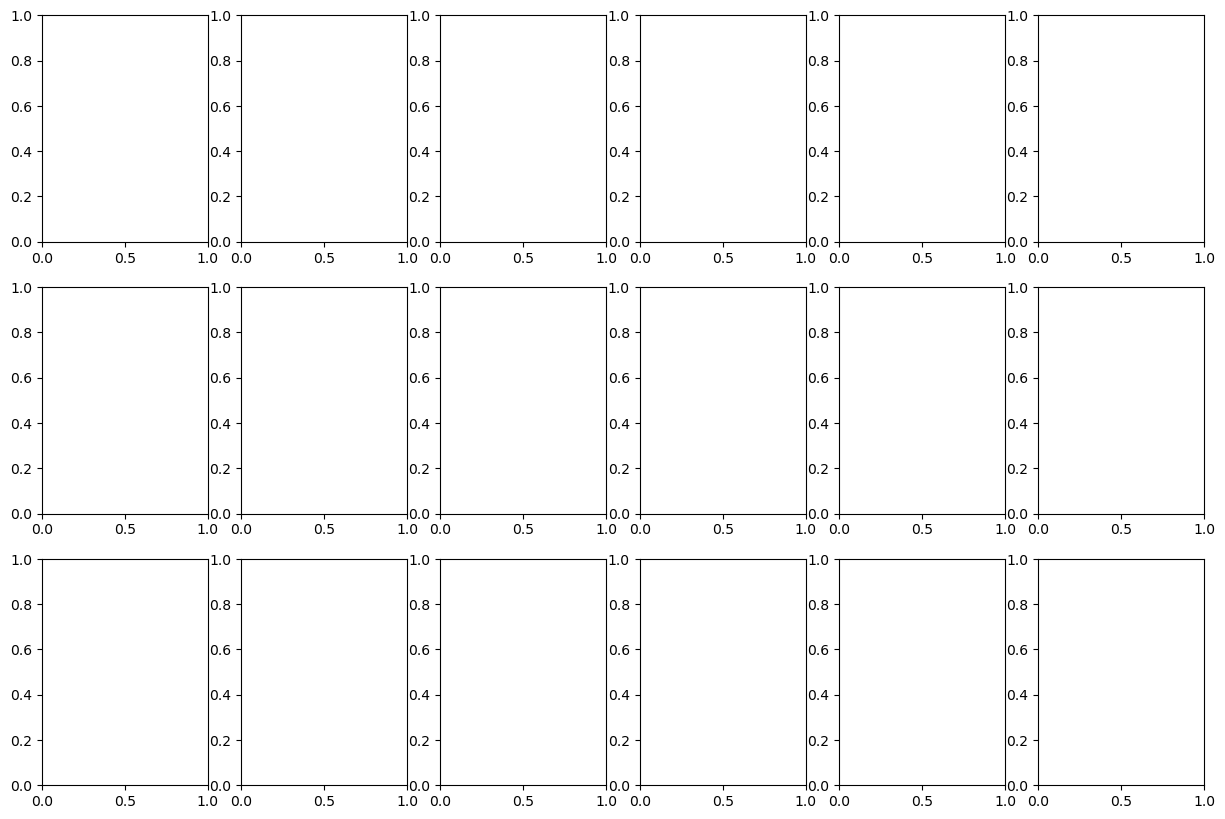

In [23]:
colors = ["red", "orange", "green", "blue", "purple", "pink", "brown", "gray", "black", "white"]
for level in range(1, 6):
    # Create subplots
    fig, axs = plt.subplots(3, 6, figsize=(15, 10))
    marker_size = 5  # Set the desired marker size
    line_width = 2   # Set the desired line width

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    for index, model in enumerate(model_list):
        budget_list = gen_budget_list(1, dataset, model)
        model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
        for prompt_type in model_prompt_list:
            if "hard" in prompt_type:
                axs[index].plot(budget_list[1:], [level_acc["Level "+str(level)] for level_acc in model_level_acc_dicts[model][prompt_type][1:]], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
            elif "sbs" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [level_acc["Level "+str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="orange", label="sbs", linewidth=line_width)
            elif "c2f" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [level_acc["Level "+str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="green", label="c2f", linewidth=line_width)
            elif "kf" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [level_acc["Level "+str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="blue", label="kf", linewidth=line_width)
            elif "aav" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [level_acc["Level "+str(level)] for level_acc in model_level_acc_dicts[model][prompt_type]], linestyle='-', color="purple", label="aav", linewidth=line_width)
            axs[index].set_xlabel("Token Budget")
            axs[index].set_ylabel("Accuracy")
            axs[index].set_title(f"{model.split('/')[-1]}")
            axs[index].legend()
            
            # Set y-axis and x-axis ticks
            axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
            # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

    # set the title
    plt.suptitle(f"{dataset}".upper() + " Level " + str(level))
    # Adjust layout
    plt.tight_layout()
    plt.show()

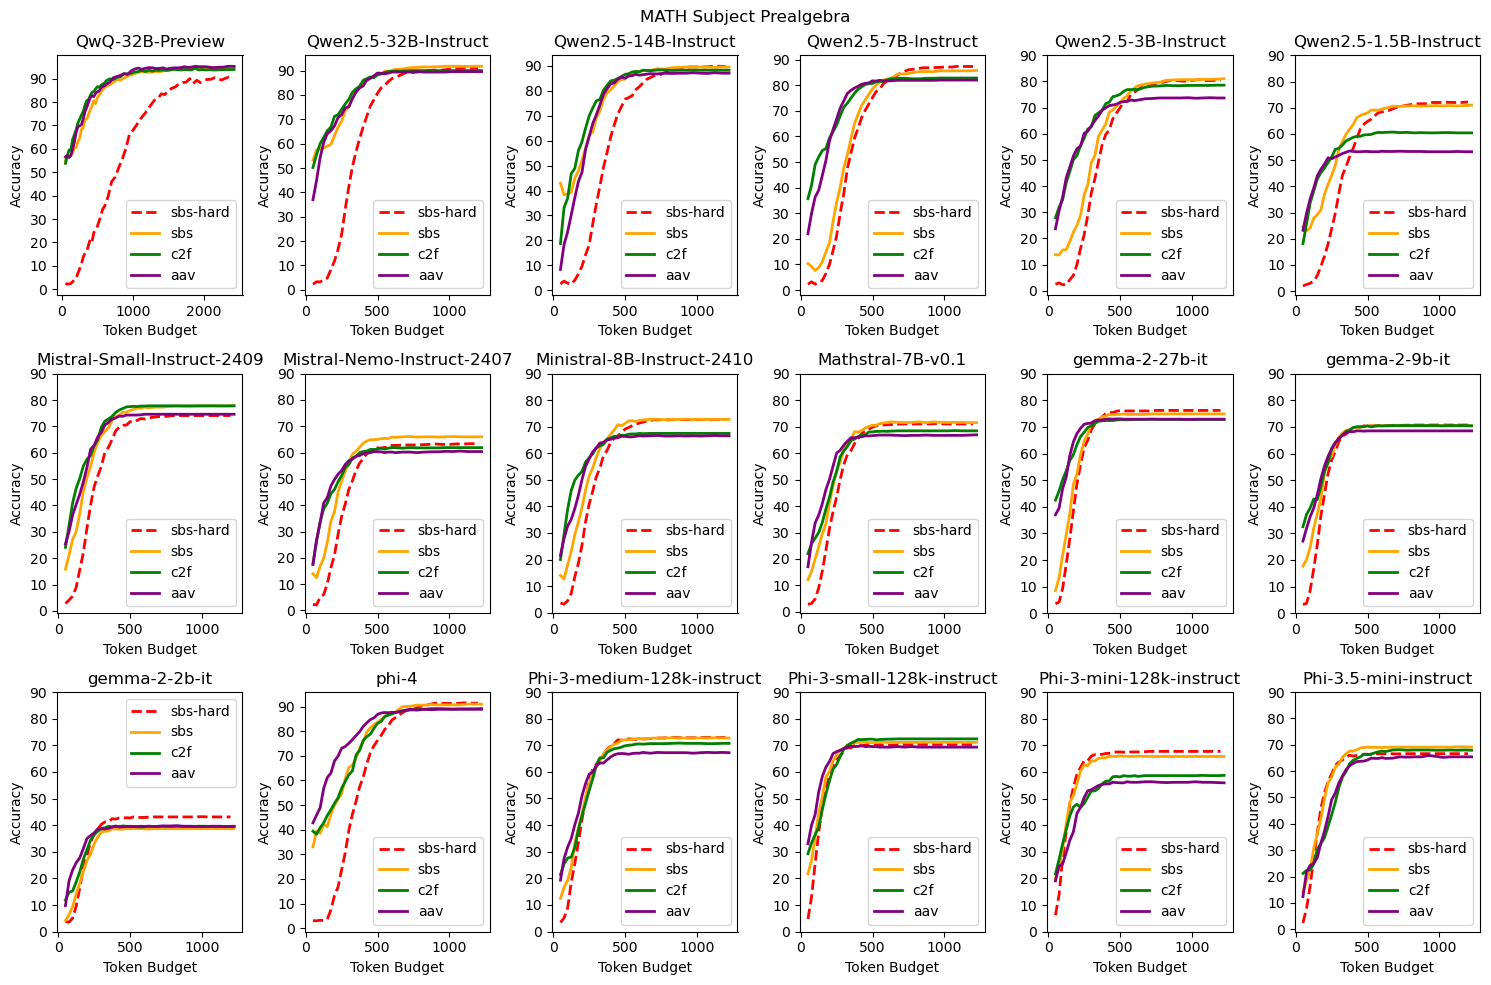

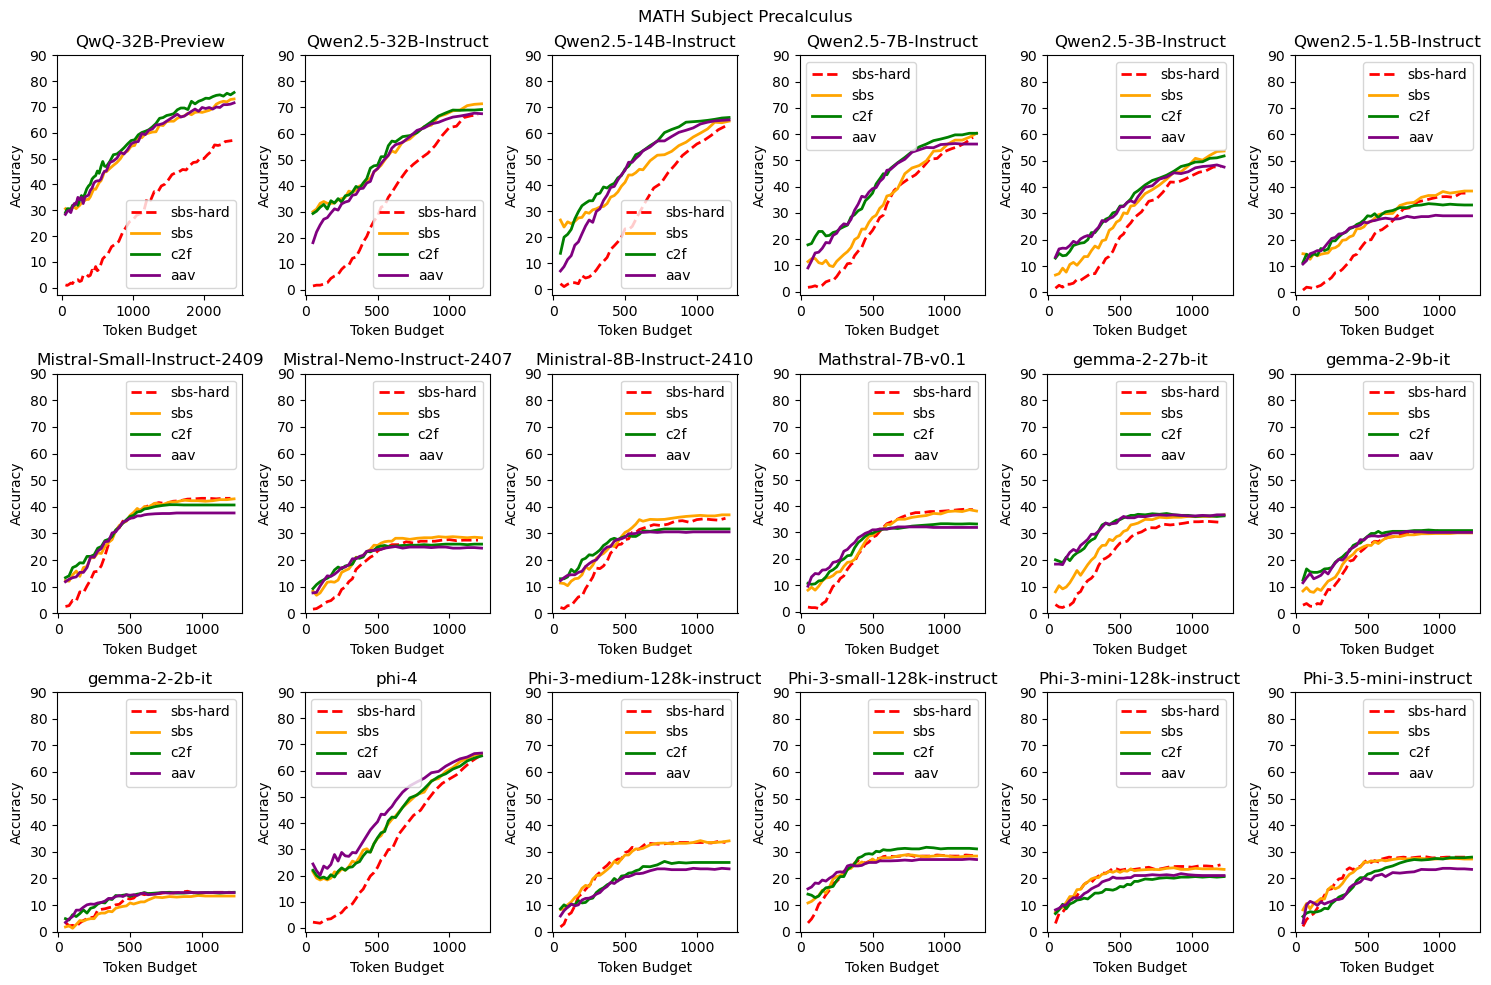

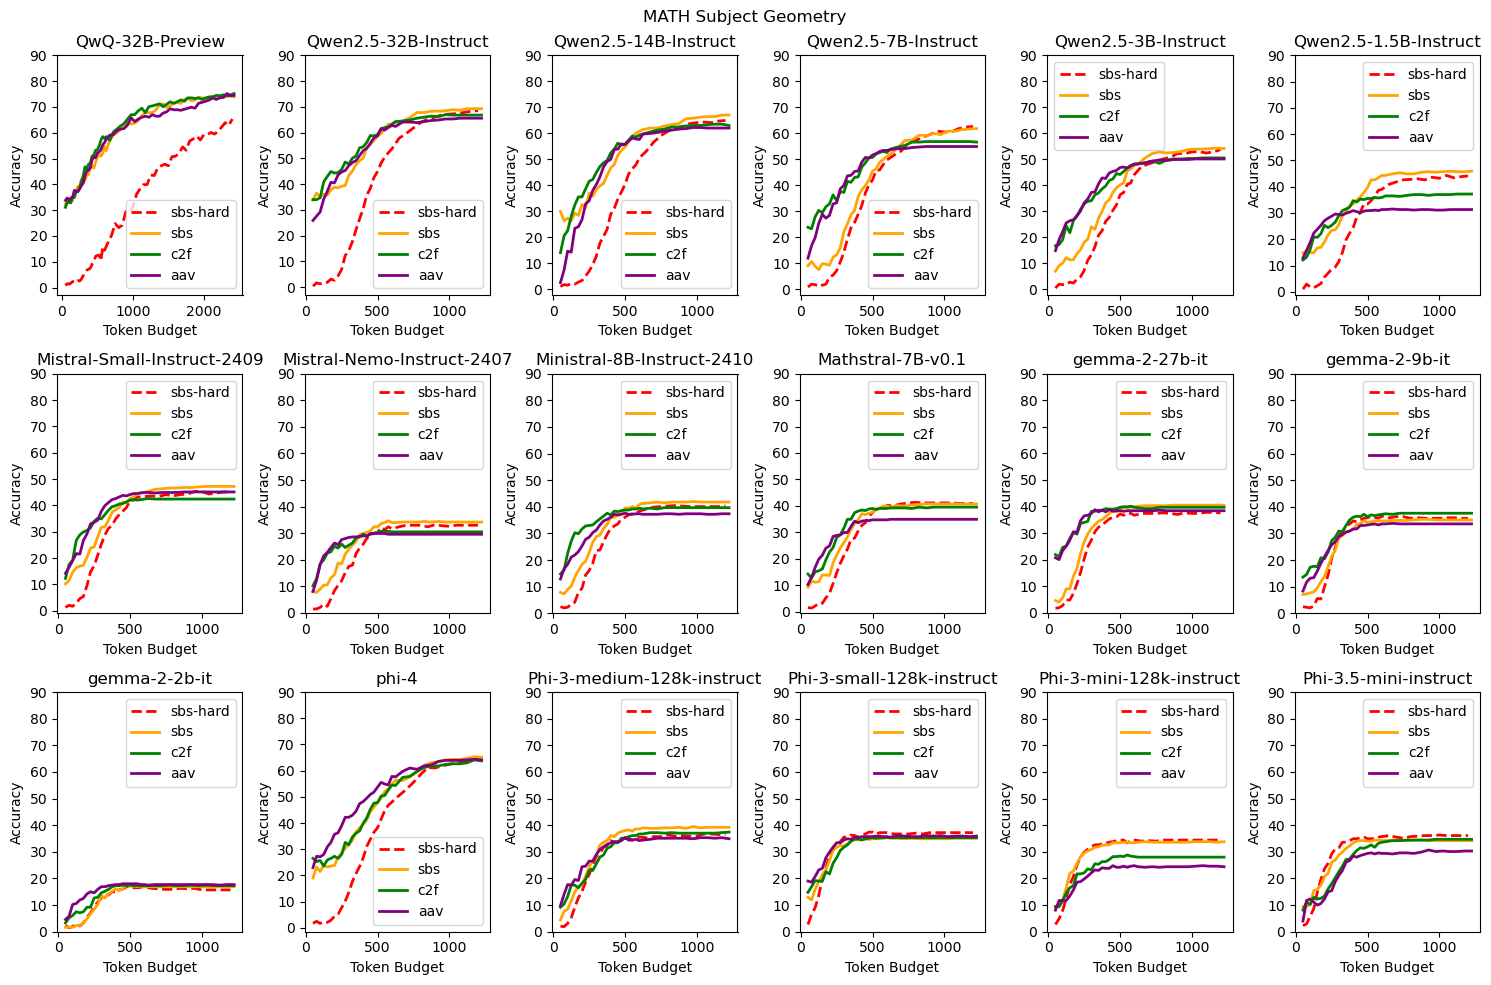

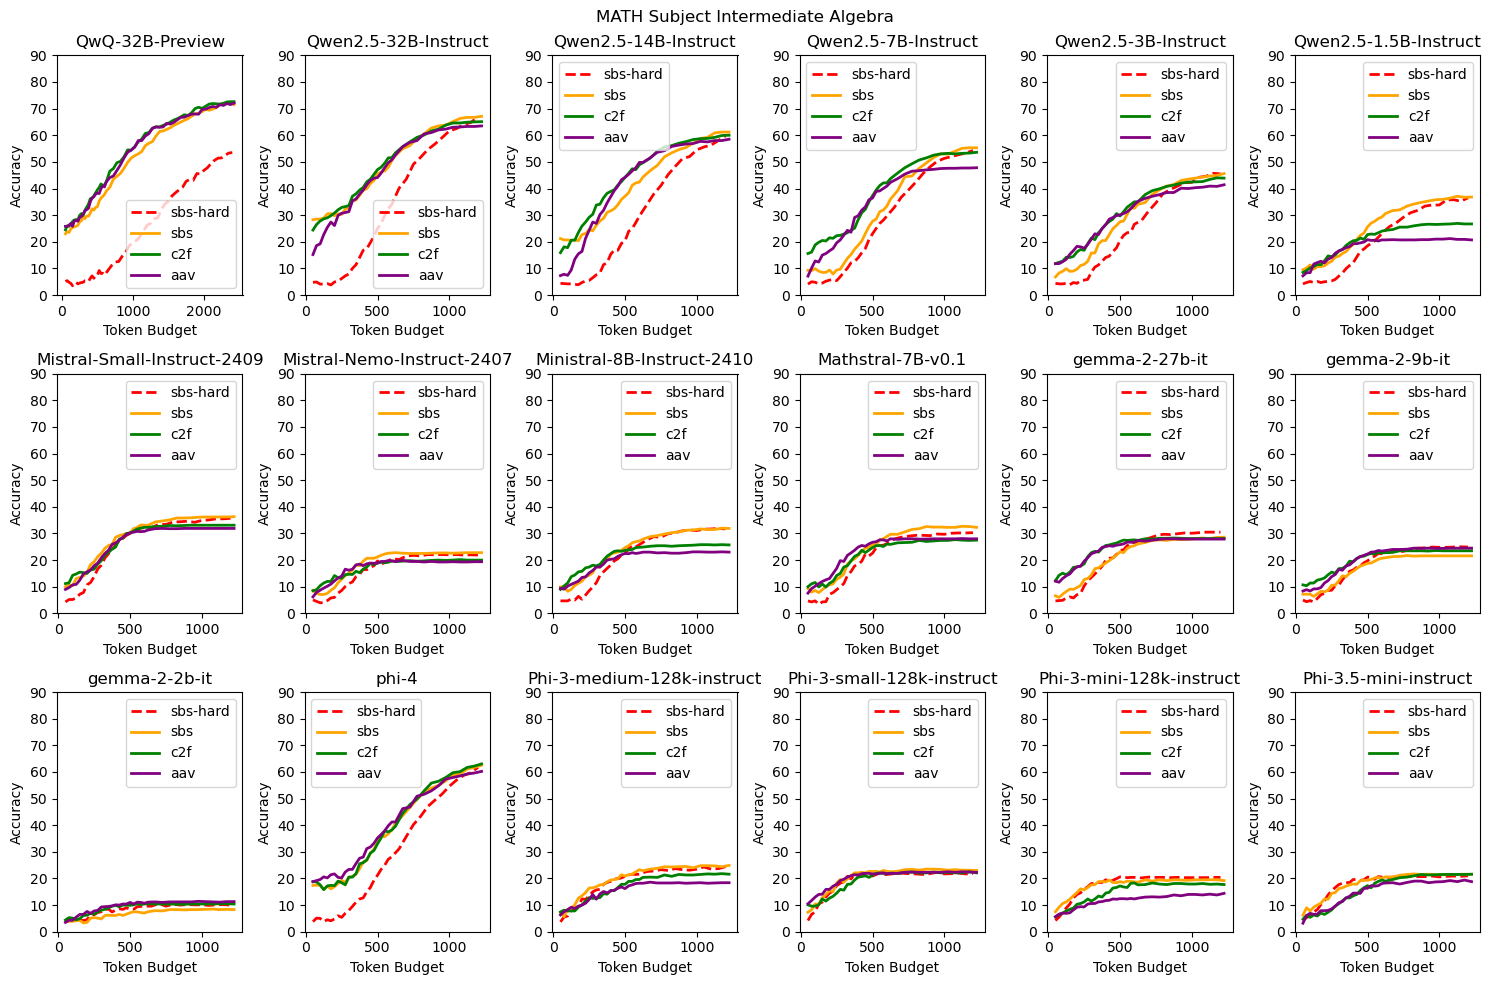

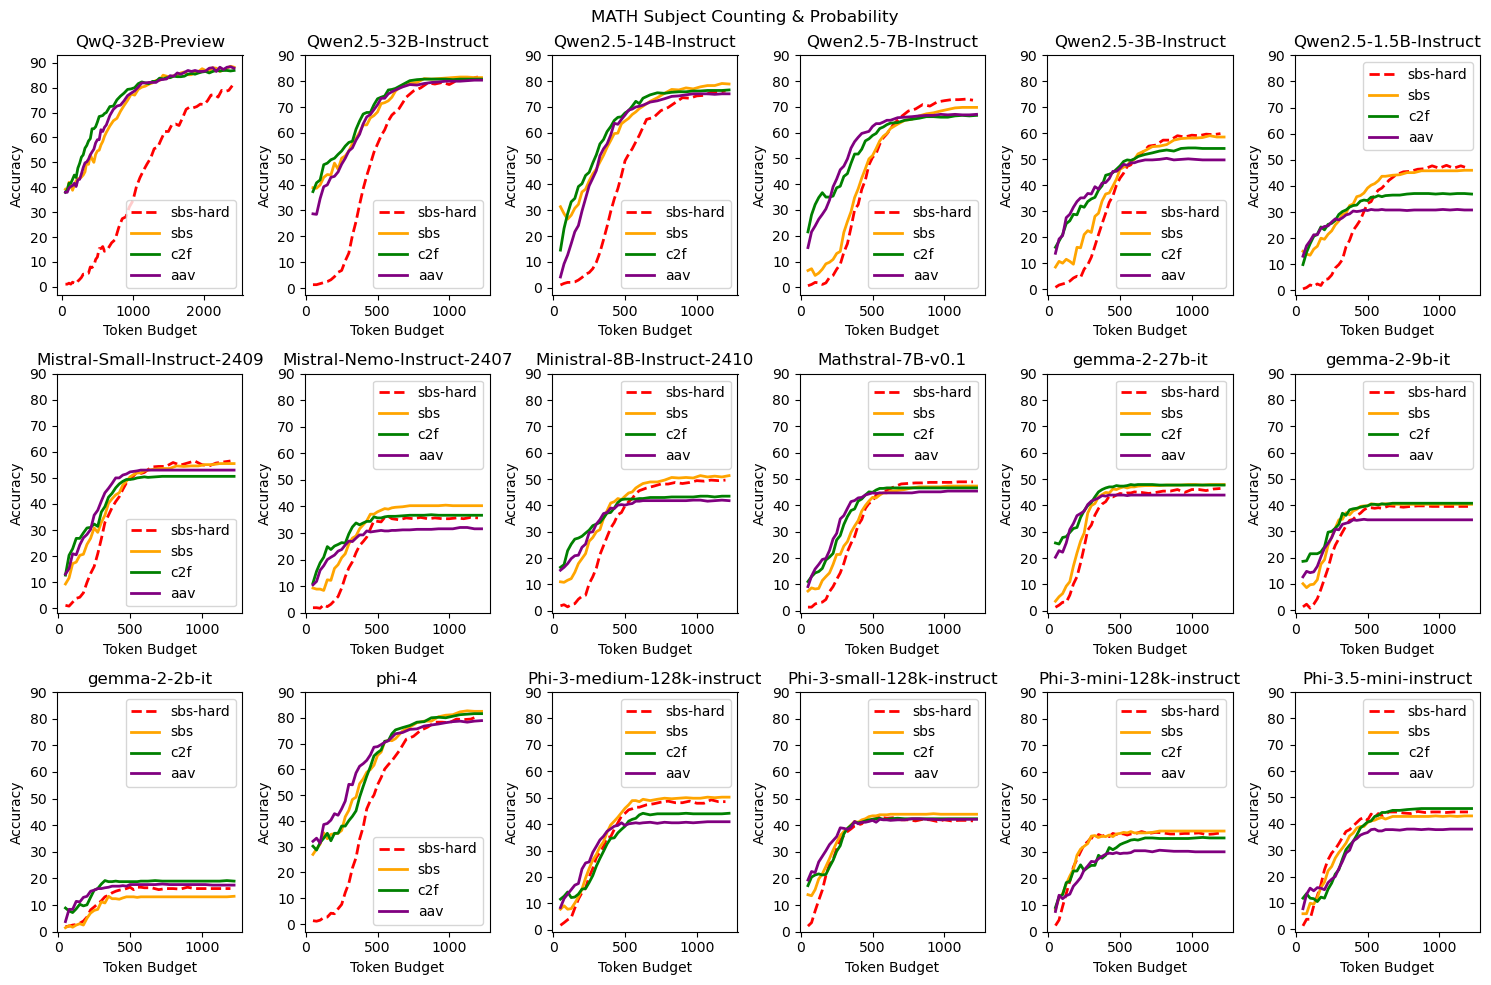

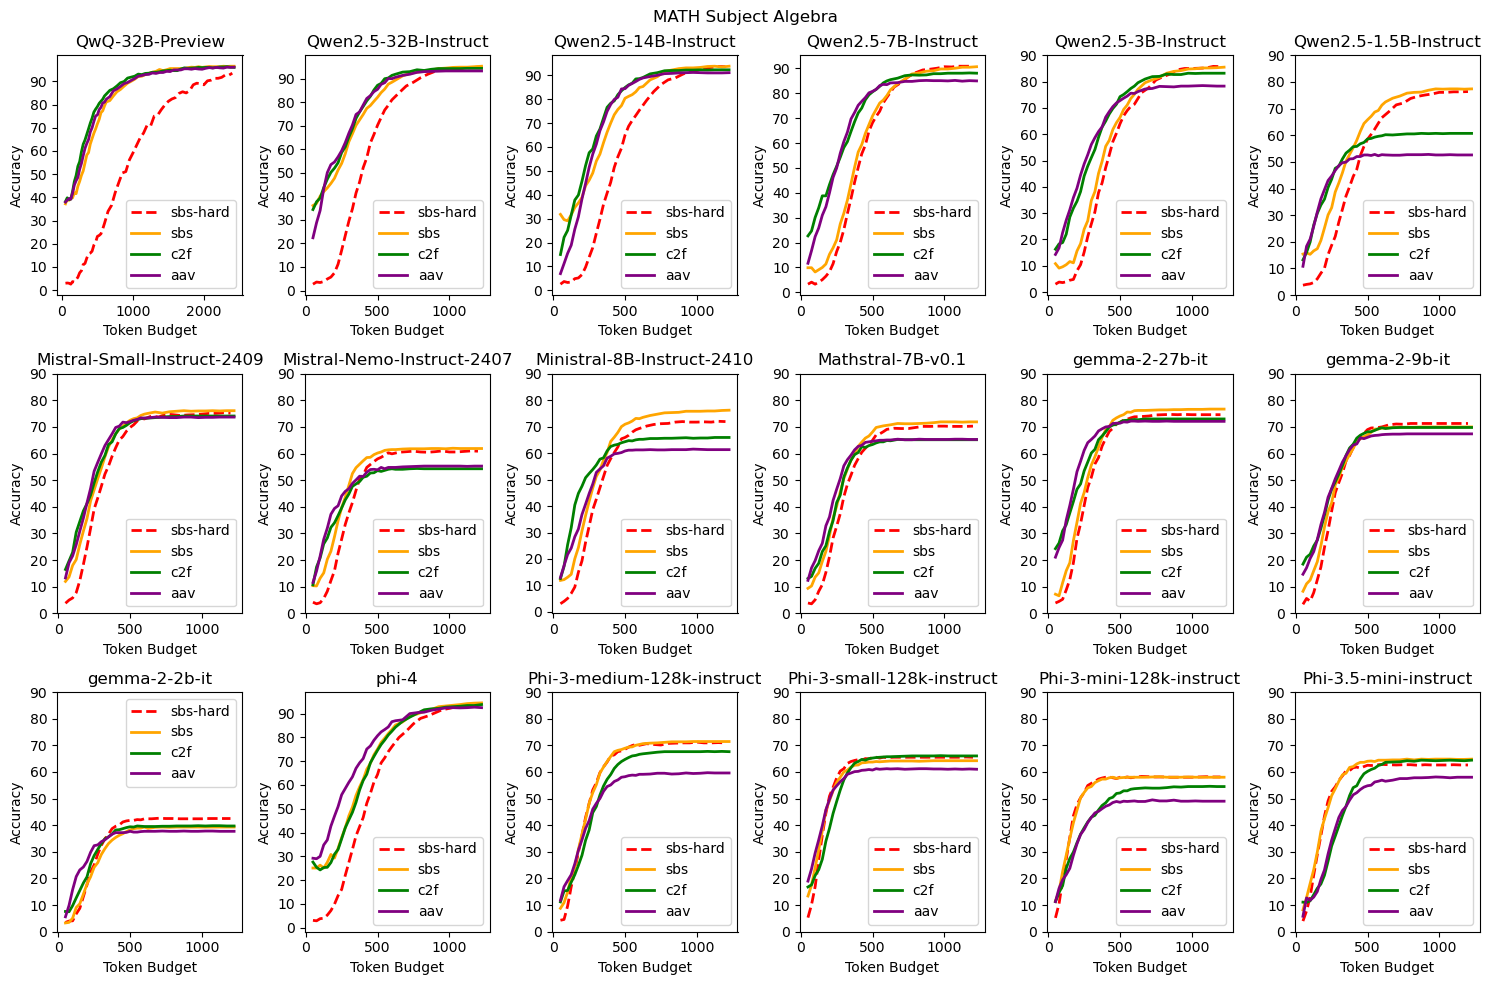

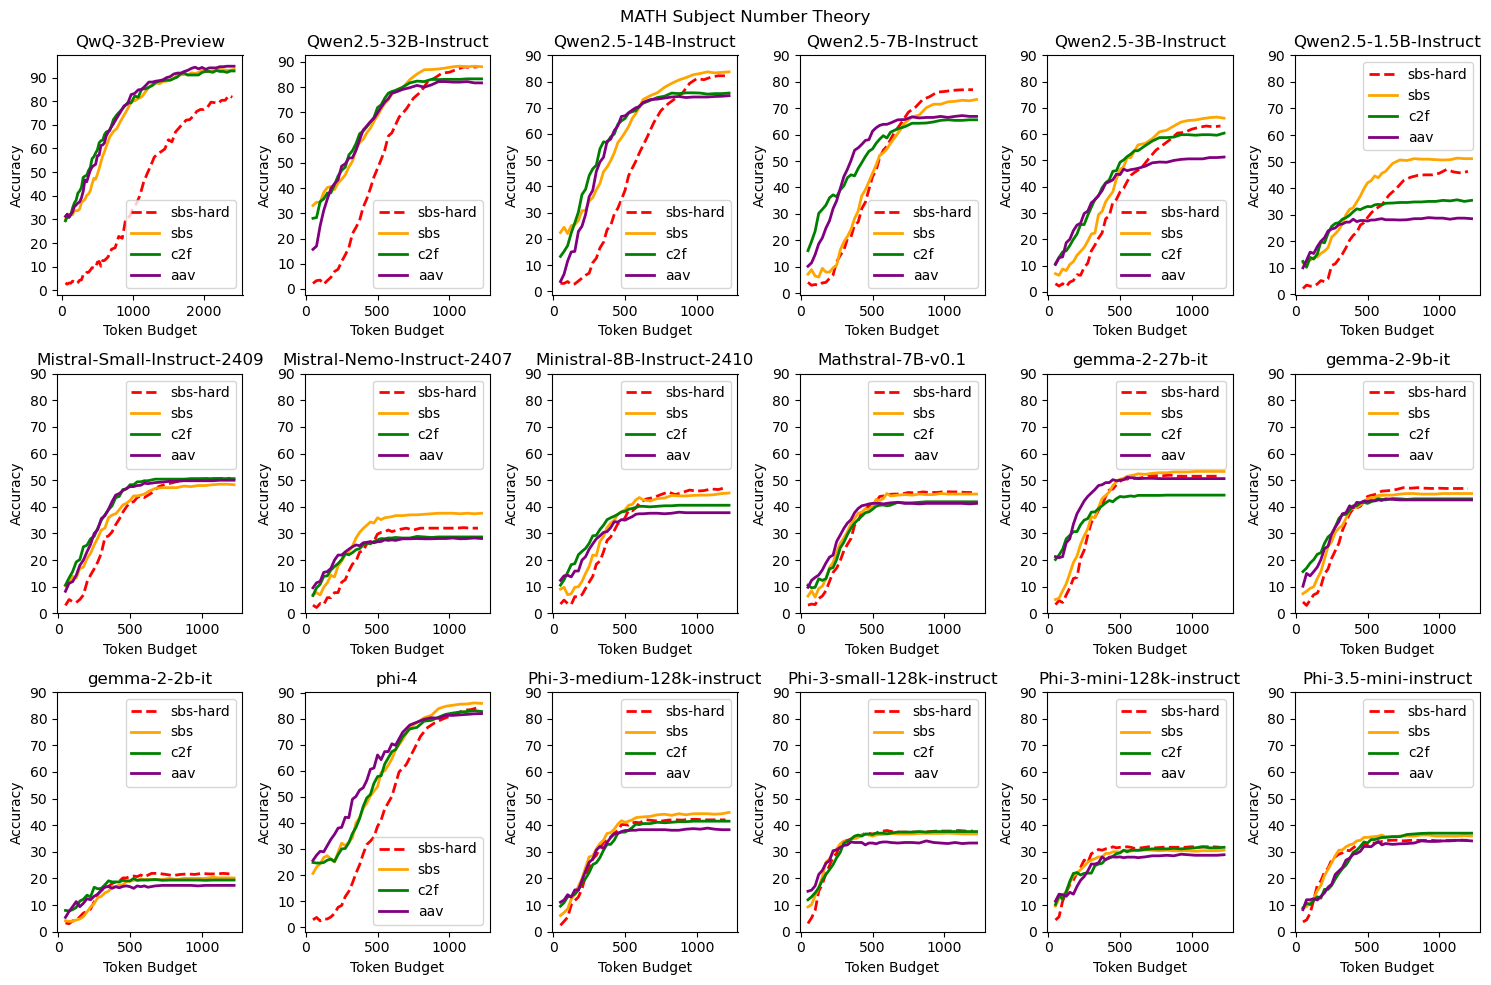

In [ ]:
colors = ["red", "orange", "green", "blue", "purple", "pink", "brown", "gray", "black", "white"]
for subject in ["Prealgebra", "Precalculus", "Geometry", "Intermediate Algebra", "Counting & Probability", "Algebra", "Number Theory"]:
    # Create subplots
    fig, axs = plt.subplots(3, 6, figsize=(15, 10))
    marker_size = 5  # Set the desired marker size
    line_width = 2   # Set the desired line width

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    for index, model in enumerate(model_list):
        budget_list = gen_budget_list(1, dataset, model)
        model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
        for prompt_type in model_prompt_list:
            if "hard" in prompt_type:
                axs[index].plot(budget_list[1:], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type][1:]], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
            elif "sbs" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="orange", label="sbs", linewidth=line_width)
            elif "c2f" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="green", label="c2f", linewidth=line_width)
            elif "kf" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="blue", label="kf", linewidth=line_width)
            elif "aav" in prompt_type:
                axs[index].plot([budget + 25 for budget in budget_list], [subject_acc[subject] for subject_acc in model_subject_acc_dicts[model][prompt_type]], linestyle='-', color="purple", label="aav", linewidth=line_width)
            axs[index].set_xlabel("Token Budget")
            axs[index].set_ylabel("Accuracy")
            axs[index].set_title(f"{model.split('/')[-1]}")
            axs[index].legend()
            
            # Set y-axis and x-axis ticks
            axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
            # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

    # set the title
    plt.suptitle(f"{dataset}".upper() + " Subject " + subject)
    # Adjust layout
    plt.tight_layout()
    plt.show()